# Простой генератор данных для домашнего задания
Можете побаловаться в генерации и настройках

In [40]:
import pandas as pd
import numpy as np

# Настройки для симуляции данных
np.random.seed(42)  # Для воспроизводимости результатов
num_days = 25
min_users_per_day = 134
max_users_per_day = 412
date_range = pd.date_range(start='2024-02-01', periods=num_days, freq='D')

# Генерация количества пользователей в день
users_per_day = np.random.randint(min_users_per_day, max_users_per_day + 1, size=num_days)

# Инициализация DataFrame
data = pd.DataFrame({
    "date": np.repeat(date_range, users_per_day),
    "group": np.nan,  # Будет заполнено позже
    "conversion": np.nan,  # Будет заполнено позже
    "LTV": np.nan  # Будет заполнено позже
})

# Заполнение групп аб теста
data["group"] = np.random.choice([0, 1], size=len(data))

# Заполнение конверсий с небольшим преимуществом для группы 1
conversion_rates = {0: 0.2, 1: 0.22}  # Небольшое преимущество для группы 1
data["conversion"] = data["group"].map(lambda g: np.random.choice([0, 1], p=[1-conversion_rates[g], conversion_rates[g]]))

# Заполнение LTV с небольшим преимуществом для группы 1
ltv_means = {0: 100, 1: 110}  # Средние значения LTV для каждой группы
ltv_std_dev = 20  # Стандартное отклонение LTV
data["LTV"] = data["group"].map(lambda g: np.maximum(0, np.random.normal(ltv_means[g], ltv_std_dev)))

data.head()

,date,group,conversion,LTV
0,2024-02-01,1,0,106.245460
1,2024-02-01,0,0,116.812134
2,2024-02-01,1,0,93.494161
3,2024-02-01,1,0,100.141635
4,2024-02-01,0,0,59.795667


# Анализ и тесты
Здесь ваша практика

In [5]:
# импортируем библиотеки для проведения анализа результата эксперимента

from scipy.stats import (
    mannwhitneyu, # https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.mannwhitneyu.html#scipy.stats.mannwhitneyu
    chi2_contingency, # https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.chi2_contingency.html#scipy.stats.chi2_contingency
    ttest_ind # https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind.html#scipy.stats.ttest_ind
    )

In [8]:
# посмотрев на распределение гуппы конверсий в регистрацию,
# можем сделать вывод, что у нас дискретные величины, к которым можно применить метод хи квадрата

for group in data.group.unique():
    data[data.group == group].conversion.hist(bins=3, alpha=.5)

NameError: name 'data' is not defined

### Здесь необходимо рассчитать результатаы теста:

In [7]:
# можно смело проводить анализ конверсии методом хи квадрата


# подготовим данные в виде сводной таблицы
conversion_table = data.pivot_table(index='group', columns='conversion', aggfunc='size', fill_value=0)
display(conversion_table)
 
statistic, p_value, _, _ = chi2_contingency(conversion_table)
print ('Статистика:', statistic)
print ('р-значение:', p_value)
# Здесь необходимо провести анализ и сделать вывод, используя chi2_contingency

NameError: name 'data' is not defined

,date,group,visit_to_reg
,,,
0,2024-02-01,0,0.176471
1,2024-02-02,0,0.223404
2,2024-02-03,0,0.187500
3,2024-02-04,0,0.175926
4,2024-02-05,0,0.268750


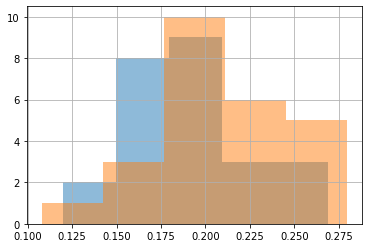

In [58]:
# подготовим данные для U и T тестов, преобразовав дискретные значения колонки conversion в неприрывные

groupped_data = data.groupby(['group', 'date']).agg({ # группируем данные по дате и группе в тесте
    'conversion': ['count', 'sum'], # подсчитываем число наблюдений и исло конвесий в день
}).reset_index() # удаляем индекс, что бы индексы group и date после группировки стали обратно колонками

# теперь расчитываем конверсию из визита в регистрацию, разделив число регистраций в день на число визитов в день
groupped_data['visit_to_reg'] = groupped_data['conversion']['sum'] / groupped_data['conversion']['count']

# оставляем только нужные нам колонки
groupped_data = groupped_data[['date', 'group', 'visit_to_reg']]
display(groupped_data.head())

for group in groupped_data.group.unique():
    groupped_data[groupped_data.group == group].visit_to_reg.hist(bins=5, alpha=.5)

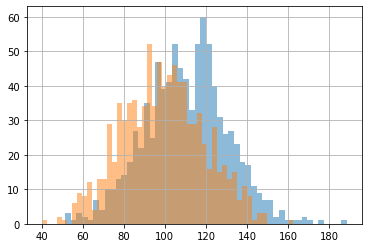

In [37]:
# Смотрим, как распределяются данные LTV

for group in data.group.unique():
    data[data.group == group].LTV.hist(bins=50, alpha=.5)

In [67]:
# проверяем оба наших набора данных методом Шапиро-Уилка на нормальность распределения,
# и как следствие возможность применения t-теста

from scipy.stats import shapiro

shapiro_visit_to_reg = {group: shapiro(groupped_data[groupped_data.group == group].visit_to_reg.values) for group in groupped_data.group.unique()}
shapiro_ltv = {group: shapiro(data[data.group == group].LTV.values) for group in data.group.unique()}

print('shapiro_visit_to_reg:')
print(shapiro_visit_to_reg)
print()
print('shapiro_ltv:')
print(shapiro_ltv)    

shapiro_visit_to_reg:
{0: ShapiroResult(statistic=0.9699720740318298, pvalue=0.6443614363670349), 1: ShapiroResult(statistic=0.9599429368972778, pvalue=0.41334009170532227)}

shapiro_ltv:
{1: ShapiroResult(statistic=0.999697208404541, pvalue=0.9122394323348999), 0: ShapiroResult(statistic=0.999453604221344, pvalue=0.4164045751094818)}


p-значение обоих распределений больше 0.05, что говорит о возможности применения t-теста для всех наших метрик.

### Здесь необходимо рассчитать результатаы теста для конверсий и LTV:

In [2]:
# t-тест для visit_to_reg
t_stat_visit_to_reg, p_value_visit_to_reg = ttest_ind(groupped_data[groupped_data.group == 'A'].visit_to_reg, groupped_data[groupped_data.group == 'B'].visit_to_reg)
print('t-тест для visit_to_reg:')
print(f't-statistic: {t_stat_visit_to_reg}, p-value: {p_value_visit_to_reg}')

# t-тест для LTV
t_stat_ltv, p_value_ltv = ttest_ind(data[data.group == 'A'].LTV, data[data.group == 'B'].LTV)
print('t-тест для LTV:')
print(f't-statistic: {t_stat_ltv}, p-value: {p_value_ltv}')

# U-тест для LTV
u_stat_ltv, p_value_ltv_u = mannwhitneyu(data[data.group == 'A'].LTV, data[data.group == 'B'].LTV)
print('U-тест для LTV:')
print(f'U-statistic: {u_stat_ltv}, p-value: {p_value_ltv_u}')

IndentationError: unexpected indent (3021086329.py, line 2)

### Сравните результаты всех тестов и сделайте выводы: